# Deep Learning with a Small Data Set

## Objective

A neural network has been trained to classify casting defects into two categories:

* Defective
* OK

The data set is [provided on kaggle](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product).  It consists of ~6000 training images and ~600 test images.  Using a relatively small CNN with ~45000 trainable parameters, it was possible to achieve excellent performance on the test set i.e. accuracy, precision and recall > 0.98.  

Often, data sets in the wild, especially in specialised domains, are:

* not as large as this

* of a lower quality.

In this notebook, the CNN used previously will be trained on a smaller set of images i.e. 250 training images and 250 test images.  The objective will be experiment with methods to obtained improved performance on small data sets.  

Since neural networks are naturally stochastic models, the results from a neural network are different every time (unless all random number generators used by the framework are carefully seeded).  Therefore, it is insightful to train several neural networks.  Subsequently, aggregate performance can be reviewed and aggregate predictions can be used.  A class was developed to facilitate this which is based on the methods discussed in [this article](https://machinelearningmastery.com/model-averaging-ensemble-for-deep-learning-neural-networks/).

The class saves all models and training history in the ensemble to a specified folder.  This is useful since it means that:

* the ensemble of models can be retrieved

* the ensemble can be added to at a later time of more models are required.

## Import Libraries 

In [1]:
import pathlib
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report,\
    accuracy_score

import casting_defects_sample_data
import casting_defects_plots
import casting_defects_models

Using TensorFlow backend.


## Setup

In [2]:
BATCH_SIZE = 64
NO_EPOCHS = 10
MODEL_NAME = 'simple_cnn'
TRAIN_NEURAL_NETWORK = False
NO_MODELS = 20
CREATE_SAMPLE = False
NO_TRAIN = 125
NO_TEST = 125

plt.style.use('ggplot')

# Setup output directory if it does not exist.
output_dir = pathlib.Path().cwd() / 'output'
try:
    output_dir.mkdir()
except FileExistsError:
    pass

The setup parameters are:

* __BATCH_SIZE__.  Size of mini-batch.
* __NO_EPOCHS__. Number of epochs to train over.
* __MODEL_NAME__. Name of directory for storing the model and history.
* __TRAIN_NEURAL_NETWORK__. A boolean specifying whether more neural networks should be trained and added to the ensemble.
* __NO_MODELS__.  If __TRAIN_NEURAL_NETWORK__ is set to true, the number of models to train.
* __CREATE_SAMPLE__. A boolean specifying whether to generate a data sample.
* __NO_TRAIN__.  Number of training examples to sample for 'small' sample data set.
* __NO_TEST__.  Number of test examples to sample for 'small' sample data set.

## Sample Data

In order to generate a simulated 'small' dataset, the images are sampled by creating a directory containing a random selection (without replacement) of symbolic links to images in the original data set.

In [3]:
# Take a sample of the original data. 
orig_dir = pathlib.Path.cwd().parent  / 'input'
sample_dir = pathlib.Path().cwd() / 'sample_data/'

if CREATE_SAMPLE: 
    casting_defects_sample_data.sample_data(
        orig_dir, sample_dir, no_train=NO_TRAIN, no_test=NO_TEST)

## Instantiate Image Generators

In [4]:
# Instantiate image generators on sampled data.
input_dir = sample_dir
data_sets = ('train', 'test')
train_dir, test_dir = [next(input_dir.rglob(ds)) for ds in data_sets]

trainval_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)

##  Define Model Architecture

In [5]:
# Create neural network architecture.
model = Sequential([
    Conv2D(32, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    MaxPool2D(4),
    Conv2D(64, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    MaxPool2D(4),
    Conv2D(32, kernel_size=3, input_shape=(300, 300, 1), activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

## Model Ensemble

A class has been developed to provide utilities for training, evaluating and predicting with an ensemble of neural networks.

In [6]:
# Instantiate a custom CastingDefectsModels class.
# Provides methods for training , evaluating and predicting on and 
# ensemble of models. 
cdf = casting_defects_models.CastingDefectModels(
    train_dir=train_dir,
    test_dir=test_dir,
    output_dir=output_dir / MODEL_NAME,
    trainval_datagen=trainval_datagen,
    test_datagen=test_datagen,
    model=model,
    no_epochs=NO_EPOCHS
)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


Some example plots can be generated to verify that the image generator is generating feasible image data; this is particularly important when *image augmentation* is applied.

Found 125 images belonging to 1 classes.
Found 125 images belonging to 1 classes.


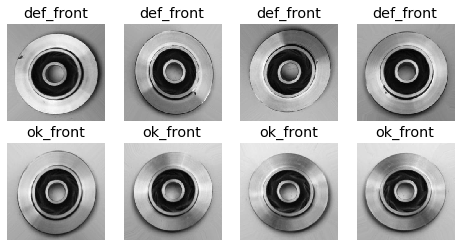

In [7]:
# Generate some examples of pre-processed images.
example_plot = cdf.generate_examples(nrows=1, ncols=4)

Now, the models can be trained if required.

In [8]:
# Train models.
if TRAIN_NEURAL_NETWORK:
    cdf.train_models(no_models=NO_MODELS)

history = cdf.gather_ensemble_history()

The ensemble of histories of currently and previously trained models is plotted as follows.

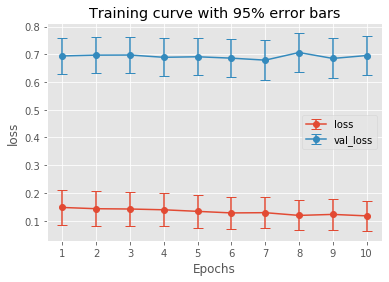

In [9]:
plot_ensemble_hist = cdf.plot_ensemble_history('loss') 

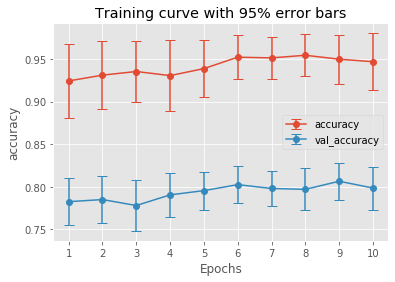

In [10]:
plot_ensemble_hist = cdf.plot_ensemble_history('accuracy') 

## Evaluation

Predictions for each model in the ensemble are computed.

In [11]:
pred_prob, raw_predictions = cdf.ensemble_predictions()

# True class.
true_class = cdf.test_generator.classes

Predicting with model #0001: model_1a66d99b-34aa-4a8c-ab06-0999a12aa022.h5
Predicting with model #0002: model_f0be5b32-ee49-4400-aecf-9b7aec0d0f22.h5
Predicting with model #0003: model_dd2ecaa2-a3b6-47c2-8fca-4c60606e9661.h5
Predicting with model #0004: model_3173cdc9-1609-43d2-b18b-fa2c9282ac16.h5
Predicting with model #0005: model_2448e13e-7653-4f18-a034-649348296cfe.h5
Predicting with model #0006: model_aa90fa25-a05b-4f45-92d0-818210dd17e2.h5
Predicting with model #0007: model_bd372be7-5894-4241-9de8-bbf1fcc6929b.h5
Predicting with model #0008: model_c53c2675-b52a-47a2-a01e-b3664a73e437.h5
Predicting with model #0009: model_80e19a57-67be-48a2-93cb-ab98760e0ed7.h5
Predicting with model #0010: model_0fd821b9-2252-4dff-a954-79f5a8a6119c.h5
Predicting with model #0011: model_94047ffb-0c0a-417b-a6be-f1169cabb59b.h5
Predicting with model #0012: model_866540e8-f16b-494c-b8cd-9837cb980927.h5
Predicting with model #0013: model_95420c2d-717d-4de4-a0e6-dfb8d1812cf0.h5
Predicting with model #00

### Distribution of Accuracy 

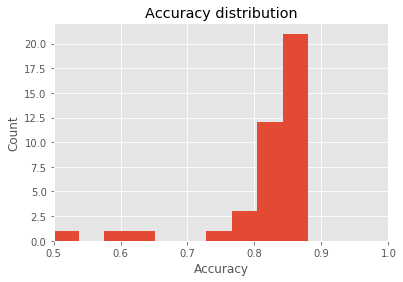

In [12]:
acc_scores = []
for y_pred_i in raw_predictions:
    acc_scores.append(accuracy_score(true_class, y_pred_i > 0.5))

fig, ax = plt.subplots()

ax.hist(acc_scores, bins=10)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Count')
ax.set_xlim(0.5, 1)
_ = ax.set_title('Accuracy distribution')

### Confusion Matrix

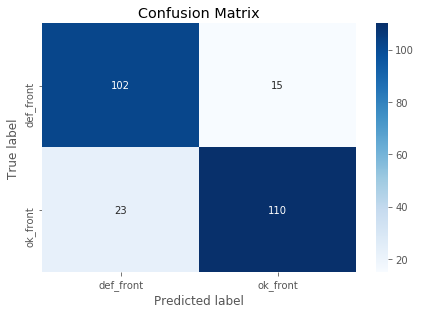

In [13]:
# Predicted class
pred_class = [elem > 0.5 for elem in pred_prob['mean']]


# Get label/target encoding.
class_indices = [[k, v] for k, v in cdf.test_generator.class_indices.items()]
target_names, labels = list(zip(*class_indices))
cm = confusion_matrix(pred_class, true_class)

casting_defects_plots.plot_confusion_matrix(cm, labels=target_names)

### Classification Report

In [14]:
print(classification_report(pred_class, true_class,
                            labels=labels, target_names=target_names))

              precision    recall  f1-score   support

   def_front       0.82      0.87      0.84       117
    ok_front       0.88      0.83      0.85       133

    accuracy                           0.85       250
   macro avg       0.85      0.85      0.85       250
weighted avg       0.85      0.85      0.85       250



### Aggregate Predictions

No handles with labels found to put in legend.


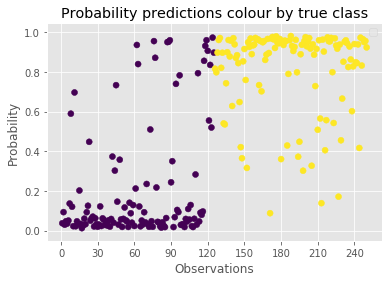

In [15]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots()

mean_prob = pred_prob['mean']
std_err_prob = pred_prob['std_err']

ax.scatter(x=range(1, len(mean_prob) + 1),
           y=mean_prob,
           c=true_class)
ax.set_title('Probability predictions colour by true class')
ax.set_xlabel('Observations')
ax.set_ylabel('Probability')
ax.legend()
_ = ax.xaxis.set_major_locator(MaxNLocator(integer=True))
